# FastF1 Classification Baseline

This notebook loads the dataset and trains a simple logistic regression baseline.

In [1]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
    confusion_matrix,
)


In [2]:
FEATURES = [
    'year',
    'round',
    'avg_race_lap_time_s',
    'lap_delta_vs_event_mean_s',
    'quali_position',
    'prev_points_total',
    'rolling_points_last3',
    'driver_points_per_race',
    'team_prev_points_total',
    'team_points_per_race',
]
TARGET = 'scored_points'
data_path = Path('data/grandprix_features_3.csv')

df_model = pd.read_csv(data_path)

# Ensure new feature columns exist even if using older CSV
defaults = {
    'lap_delta_vs_event_mean_s': 0.0,
    'rolling_points_last3': 0.0,
    'driver_points_per_race': 0.0,
    'team_prev_points_total': 0.0,
    'team_points_per_race': 0.0,
}
for col, val in defaults.items():
    if col not in df_model.columns:
        df_model[col] = val
print(f"Rows after cleaning: {len(df_model)}")
df_model.head()


Rows after cleaning: 1839


,year,round,event,driver,team,quali_position,avg_race_lap_time_s,lap_delta_vs_event_mean_s,finish_position,points_awarded,prev_points_total,rolling_points_last3,driver_points_per_race,team_prev_points_total,team_points_per_race,scored_points
0,2020,1,Austrian Grand Prix,BOT,Mercedes,1.0,68.851635,-1.140119,1.0,25.0,0.0,0.0,0.0,0.0,0.0,1
1,2020,1,Austrian Grand Prix,LEC,Ferrari,7.0,69.497360,-0.494394,2.0,18.0,0.0,0.0,0.0,0.0,0.0,1
2,2020,1,Austrian Grand Prix,NOR,McLaren,4.0,69.444060,-0.547694,3.0,16.0,0.0,0.0,0.0,0.0,0.0,1
3,2020,1,Austrian Grand Prix,HAM,Mercedes,2.0,68.789760,-1.201994,4.0,12.0,0.0,0.0,0.0,25.0,25.0,1
4,2020,1,Austrian Grand Prix,SAI,McLaren,8.0,69.676180,-0.315574,5.0,10.0,0.0,0.0,0.0,16.0,16.0,1


In [3]:
X = df_model[FEATURES]
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((1471, 10), (368, 10))

Pipeline: Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=200))])
CV ROC-AUC: 0.893 ± 0.021
CV PR-AUC (avg precision): 0.880 ± 0.029

Holdout classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       186
           1       0.83      0.81      0.82       182

    accuracy                           0.82       368
   macro avg       0.82      0.82      0.82       368
weighted avg       0.82      0.82      0.82       368

Holdout ROC-AUC: 0.9031667257473709
Holdout PR-AUC (avg precision): 0.893927689871212

Additional metrics:
Precision: 0.8305084745762712
Recall: 0.8076923076923077
F1 (binary): 0.8189415041782729
F1 (macro): 0.8232638555374123
Confusion matrix (raw):
 [[156  30]
 [ 35 147]]

Confusion matrix as table:


,Pred 0,Pred 1
Actual 0,156,30
Actual 1,35,147


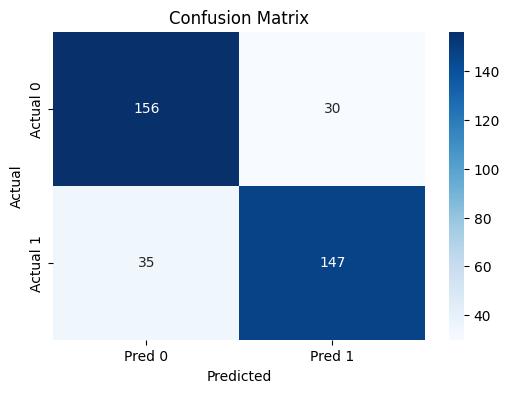

In [4]:
# Logistic regression baseline (imputer + scaler)
log_reg = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LogisticRegression(max_iter=200, class_weight='balanced'),
)
print("Pipeline:", log_reg)

# Cross-validation: ROC-AUC and PR-AUC (average_precision)
cv_auc = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='roc_auc')
cv_pr = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='average_precision')
print(f'CV ROC-AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}')
print(f'CV PR-AUC (avg precision): {cv_pr.mean():.3f} ± {cv_pr.std():.3f}')

# Fit on training data
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Holdout evaluation
print('\nHoldout classification report:')
print(classification_report(y_test, y_pred))
print('Holdout ROC-AUC:', roc_auc_score(y_test, y_proba))
print('Holdout PR-AUC (avg precision):', average_precision_score(y_test, y_proba))
print('\nAdditional metrics:')
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 (binary):', f1_score(y_test, y_pred))
print('F1 (macro):', f1_score(y_test, y_pred, average="macro"))

# Confusion matrix (numeric) and visualization as table + heatmap
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix (raw):\n', cm)

# Visualization: DataFrame table and seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

cm_df = pd.DataFrame(
    cm,
    index=[f'Actual {i}' for i in range(cm.shape[0])],
    columns=[f'Pred {i}' for i in range(cm.shape[1])],
)

print('\nConfusion matrix as table:')
display(cm_df)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
